In [1]:
%matplotlib inline
# Load all necessary packages
import sys
import pandas  as pd
import numpy   as np
import seaborn as sns
sns.set()
sns.set_context("talk")
import matplotlib.pyplot as plt
# Import IBM's AI Fairness tooolbox
from aif360.datasets         import BinaryLabelDataset
from aif360.metrics          import BinaryLabelDatasetMetric
from aif360.metrics          import ClassificationMetric
from aif360.metrics.utils    import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.lfr import LFR
# Import scikit-learn core slibraries
from sklearn.metrics         import auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split  
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import balanced_accuracy_score
from sklearn.preprocessing   import StandardScaler, MinMaxScaler
from sklearn.metrics         import accuracy_score
from IPython.display         import Markdown, display
from typing                  import List, Union, Dict
# Warnings will be used to silence various model warnings for tidier output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the cleaned German dataset
German_df = pd.read_csv('./input/German-Cleaned.csv')

In [3]:
# Set privileged (1)/ unprivileged (0)/ favourable (1) / unfavourable values (0)
protected_attr      = 'Gender'
priv_grp            = 1  # Males 
unpriv_grp          = 0  # Females  
lab                 = 'CreditStatus'
fav_label           = 1 # Good Credit status
unfav_label         = 0 # Bad Credit Status
privileged_groups   = [{protected_attr: priv_grp}]   # Males
unprivileged_groups = [{protected_attr: unpriv_grp}] # Females

In [4]:
# Create a Binary Label Dataset to use with AIF360 APIs
X = German_df.drop(lab,axis=1)
y = German_df[lab]

In [5]:
German_bld = BinaryLabelDataset(df=pd.concat((X, y), axis=1),
                                label_names=[lab], protected_attribute_names=[protected_attr],
                                favorable_label=fav_label, unfavorable_label=unfav_label)

In [6]:
# Create train and test datasets
German_train_bld, German_test_bld = German_bld.split([0.7], shuffle=True, seed=101)

In [7]:
scaler = MinMaxScaler(copy=False)
German_train_bld.features = scaler.fit_transform(German_train_bld.features)
German_test_bld.features  = scaler.fit_transform(German_test_bld.features)

In [8]:
German_train_df, d = German_train_bld.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=False)
German_test_df,  d = German_test_bld.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=False)

In [9]:
# First test whether it is possible to predict the Sensitive Variable from the whole original dataset
X_se_train = German_train_df.drop(protected_attr,axis=1)
y_se_train = German_train_df[protected_attr]
X_se_test  = German_test_df.drop(protected_attr,axis=1)
y_se_test  = German_test_df[protected_attr]

Se_BiasedLogModel = LogisticRegression(random_state=101)
Se_BiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)
Se_BiasedLogModel.fit(X_se_train, y_se_train) 
Se_BiasedRfcModel.fit(X_se_train, y_se_train) 
yseLog_pred =  Se_BiasedLogModel.predict(X_se_test)
yseRfc_pred =  Se_BiasedRfcModel.predict(X_se_test)
# Now test whether we can predict Gender from the test dataset
print('Model Accuracy for predicting the Sensitive Variable before bias transformation:')
print(f"Biased Logistic regression validation accuracy: {Se_BiasedLogModel.score(X_se_test, y_se_test)}")
print(f"Biased Random Forest       validation accuracy: {Se_BiasedRfcModel.score(X_se_test, y_se_test)}")
print('')
print('Biased Balanced accuracy')
print(f"Biased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_se_test, yseLog_pred)}")
print(f"Biased Random Forest       balanced accuracy  : {balanced_accuracy_score(y_se_test, yseRfc_pred)}")

Model Accuracy for predicting the Sensitive Variable before bias transformation:
Biased Logistic regression validation accuracy: 0.7133333333333334
Biased Random Forest       validation accuracy: 0.71

Biased Balanced accuracy
Biased Logistic regression balanced accuracy  : 0.585171568627451
Biased Random Forest       balanced accuracy  : 0.5634191176470589


In [10]:
# Next get the number of labels from the modified training dataset
print('Train ds Before - CreditStatus value counts:')
print(German_train_df.CreditStatus.value_counts())
print('Train ds Before - Gender value counts:')
print(German_train_df.Gender.value_counts())

Train ds Before - CreditStatus value counts:
1.0    475
0.0    225
Name: CreditStatus, dtype: int64
Train ds Before - Gender value counts:
1.0    486
0.0    214
Name: Gender, dtype: int64


In [11]:
# Determine the baseline model accuracy for Logistic Regression and Random Forest Classifiers
X_train = German_train_df.drop(lab,axis=1)
y_train = German_train_df[lab]
X_test  = German_test_df.drop(lab,axis=1)
y_test  = German_test_df[lab]
BiasedLogModel = LogisticRegression(random_state=101)
BiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)
BiasedLogModel.fit(X_train, y_train) 
BiasedRfcModel.fit(X_train, y_train)
BiasedLogPredictions = BiasedLogModel.predict(X_test)
BiasedRfcPredictions = BiasedRfcModel.predict(X_test)
print(f"Biased Logistic regression validation accuracy: {BiasedLogModel.score(X_test, y_test)}")
print(f"Biased Random Forest       validation accuracy: {BiasedRfcModel.score(X_test, y_test)}")
print('')
print(f"Biased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_test, BiasedLogPredictions)}")
print(f"Biased Random forest balanced accuracy        : {balanced_accuracy_score(y_test, BiasedRfcPredictions)}")

Biased Logistic regression validation accuracy: 0.75
Biased Random Forest       validation accuracy: 0.7633333333333333

Biased Logistic regression balanced accuracy  : 0.6155555555555556
Biased Random forest balanced accuracy        : 0.5711111111111111


In [12]:
#Test for equality of odds. 
Test_Log_bld = German_test_bld.copy(deepcopy=True)
Test_Rfc_bld = German_test_bld.copy(deepcopy=True)
TestLogPredictions = BiasedLogModel.predict(X_test)
TestRfcPredictions = BiasedRfcModel.predict(X_test)
Test_Log_bld.labels= TestLogPredictions
Test_Rfc_bld.labels= TestRfcPredictions

c_Log_metric = ClassificationMetric(German_test_bld, Test_Log_bld, 
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)
c_Rfc_metric = ClassificationMetric(German_test_bld, Test_Rfc_bld, 
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)

In [13]:
print('A value of 0 means that equality of odds has been met')
print('Log average_abs_odds_difference:', c_Log_metric.average_abs_odds_difference())
print('Log average_odds_difference:    ', c_Log_metric.average_odds_difference())
print(' ')
print('Rfc average_abs_odds_difference:', c_Rfc_metric.average_abs_odds_difference())
print('Rfc average_odds_difference:    ', c_Rfc_metric.average_odds_difference())

A value of 0 means that equality of odds has been met
Log average_abs_odds_difference: 0.14753127057274523
Log average_odds_difference:     -0.14753127057274523
 
Rfc average_abs_odds_difference: 0.00546918519268752
Rfc average_odds_difference:     -0.0031650377272496866


In [14]:
# Create the binary label dataset metric class for the training dataset
metric_train_bld = BinaryLabelDatasetMetric(German_train_bld, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
display(Markdown("#### Biased training dataset"))
print('Number of instances           :', metric_train_bld.num_instances())
print("Base Rate                     :%f" % metric_train_bld.base_rate())
print('Consistency                   :', metric_train_bld.consistency())
print('Disparate Impact              :', metric_train_bld.disparate_impact())
print('Mean Difference               :', metric_train_bld.mean_difference())
print('Statistical Parity Difference :', metric_train_bld.statistical_parity_difference()) 
print('# of positives(privileged)    :', metric_train_bld.num_positives(privileged=True))
print('# of positives(non-privileged):', metric_train_bld.num_positives(privileged=False))
print('Total positive instances"     :', metric_train_bld.num_positives(privileged=True)+metric_train_bld.num_positives(privileged=False))
print('# of negatives(privileged)    :', metric_train_bld.num_negatives(privileged=True))
print('# of negatives(non-privileged):', metric_train_bld.num_negatives(privileged=False))
print('Total negative instances"     :', metric_train_bld.num_negatives(privileged=True)+metric_train_bld.num_negatives(privileged=False))

#### Biased training dataset

Number of instances           : 700.0
Base Rate                     :0.678571
Consistency                   : [0.69685714]
Disparate Impact              : 0.8648391653988263
Mean Difference               : -0.09566939733087187
Statistical Parity Difference : -0.09566939733087187
# of positives(privileged)    : 344.0
# of positives(non-privileged): 131.0
Total positive instances"     : 475.0
# of negatives(privileged)    : 142.0
# of negatives(non-privileged): 83.0
Total negative instances"     : 225.0


In [15]:
# Fit the Learning Fair Representations on the biased training data
print('Interval : Optimization objective value for the interval')
TR = LFR(unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups,verbose=1, seed=101)
TR = TR.fit(German_train_bld)

Interval : Optimization objective value for the interval
250 462.84227578476924
500 449.09544854993027
750 449.1049881424335
1000 446.265834637003
1250 441.936513899342
1500 436.8836472990665
1750 422.19507900396474
2000 413.40559418833016
2250 408.5651877750997
2500 406.8081480037081
2750 404.2040938645752
3000 403.07156034081066
3250 401.8603780179831
3500 399.52938545692103
3750 398.3470869529274
4000 399.10064793423055
4250 397.22178678417043
4500 396.3473812950743
4750 395.40960672586203
5000 394.84188737502393


In [16]:
# Transform training data and align features
German_train_lfr = TR.transform(German_train_bld)

In [17]:
display(Markdown("#### Transformed training dataset"))
from sklearn.metrics import classification_report
thresholds = np.linspace(0.1, 0.9, 9)
for threshold in thresholds:
    # Transform training data and align features
    German_train_lfr = TR.transform(German_train_bld,threshold=threshold)
    metric_train_lfr = BinaryLabelDatasetMetric(German_train_lfr, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("Classification threshold = %f" % threshold)
    print('Consistency                   :', metric_train_lfr.consistency())
    print('Disparate Impact              :', metric_train_lfr.disparate_impact())
    print('Mean Difference               :', metric_train_lfr.mean_difference())
    print('')

#### Transformed training dataset

Classification threshold = 0.100000
Consistency                   : [1.]
Disparate Impact              : 1.0
Mean Difference               : 0.0

Classification threshold = 0.200000
Consistency                   : [0.99857143]
Disparate Impact              : 1.002061855670103
Mean Difference               : 0.002057613168724326

Classification threshold = 0.300000
Consistency                   : [0.99285714]
Disparate Impact              : 1.0056035165531443
Mean Difference               : 0.005442098380831539

Classification threshold = 0.400000
Consistency                   : [0.97971429]
Disparate Impact              : 1.0093457943925233
Mean Difference               : 0.008653513326410511

Classification threshold = 0.500000
Consistency                   : [0.954]
Disparate Impact              : 1.0231454439252337
Mean Difference               : 0.01828775816314765

Classification threshold = 0.600000
Consistency                   : [0.97057143]
Disparate Impact              : 1.03

In [18]:
threshold = 0.7 # Chosen because the disparate impact is closest to 1.
German_train_lfr = TR.transform(German_train_bld,threshold=threshold)

In [19]:
metric_train_lfr = BinaryLabelDatasetMetric(German_train_lfr, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

In [20]:
print('THIS IS WHAT THE AIF CODE PRODUCES FROM THE LAST CLASSIFICATION THRESHOLD RUN ABOVE')
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train_lfr.mean_difference())
print('Number of instances           :', metric_train_lfr.num_instances())
print("Base Rate                     :%f" % metric_train_lfr.base_rate())
print('Consistency                   :', metric_train_lfr.consistency())
print('Disparate Impact              :', metric_train_lfr.disparate_impact())
print('Mean Difference               :', metric_train_lfr.mean_difference())
print('Statistical Parity Difference :', metric_train_lfr.statistical_parity_difference()) 
print('# of positives(privileged)    :', metric_train_lfr.num_positives(privileged=True))
print('# of positives(non-privileged):', metric_train_lfr.num_positives(privileged=False))
print('Total positive instances"     :', metric_train_lfr.num_positives(privileged=True)+metric_train_lfr.num_positives(privileged=False))
print('# of negatives(privileged)    :', metric_train_lfr.num_negatives(privileged=True))
print('# of negatives(non-privileged):', metric_train_lfr.num_negatives(privileged=False))
print('Total negative instances"     :', metric_train_lfr.num_negatives(privileged=True)+metric_train_lfr.num_negatives(privileged=False))
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train_bld.mean_difference())

THIS IS WHAT THE AIF CODE PRODUCES FROM THE LAST CLASSIFICATION THRESHOLD RUN ABOVE
Difference in mean outcomes between unprivileged and privileged groups = 0.001115
Number of instances           : 700.0
Base Rate                     :0.508571
Consistency                   : [0.972]
Disparate Impact              : 1.0021945590071513
Mean Difference               : 0.0011153417176262836
Statistical Parity Difference : 0.0011153417176262836
# of positives(privileged)    : 247.0
# of positives(non-privileged): 109.0
Total positive instances"     : 356.0
# of negatives(privileged)    : 239.0
# of negatives(non-privileged): 105.0
Total negative instances"     : 344.0


#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.095669


In [21]:
# Convert the transformed Binary Labelled Datasets to a pandas dataframe for consistency 
German_train_lfr_df, d = German_train_lfr.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=False)

In [22]:
# Determine the transformed model accuracy for Logistic Regression and Random Forest Classifiers
X_lfr_train = German_train_lfr_df.drop(lab,axis=1)
y_lfr_train = German_train_lfr_df[lab]
X_lfr_test  = German_test_df.drop(lab,axis=1)
y_lfr_test  = German_test_df[lab]

UnbiasedLogModel = LogisticRegression(random_state=101)
UnbiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)
UnbiasedLogModel.fit(X_lfr_train, y_lfr_train) 
UnbiasedRfcModel.fit(X_lfr_train, y_lfr_train) 
UnbiasedLogPredictions = UnbiasedLogModel.predict(X_lfr_test)
UnbiasedRfcPredictions = UnbiasedRfcModel.predict(X_lfr_test)

print(f"Unbiased Logistic regression validation accuracy: {UnbiasedLogModel.score(X_lfr_test, y_lfr_test)}")
print(f"Unbiased Random Forest       validation accuracy: {UnbiasedRfcModel.score(X_lfr_test, y_lfr_test)}")
print('')
print(f"UnBiased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_lfr_test, UnbiasedLogPredictions)}")
print(f"Unbiased Random Forest       balanced accuracy  : {balanced_accuracy_score(y_lfr_test, UnbiasedRfcPredictions)}")

Unbiased Logistic regression validation accuracy: 0.51
Unbiased Random Forest       validation accuracy: 0.5033333333333333

UnBiased Logistic regression balanced accuracy  : 0.6111111111111112
Unbiased Random Forest       balanced accuracy  : 0.5755555555555556


In [23]:
#Test for equality of odds. 
Test_Log_bld = German_test_bld.copy(deepcopy=True)
Test_Rfc_bld = German_test_bld.copy(deepcopy=True)
TestLogPredictions = UnbiasedLogModel.predict(X_test)
TestRfcPredictions = UnbiasedRfcModel.predict(X_test)
Test_Log_bld.labels= TestLogPredictions
Test_Rfc_bld.labels= TestRfcPredictions

c_Log_metric = ClassificationMetric(German_test_bld, Test_Log_bld, 
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)
c_Rfc_metric = ClassificationMetric(German_test_bld, Test_Rfc_bld, 
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)

In [24]:
print('A value of 0 means that equality of odds has been met')
print('Log average_abs_odds_difference:', c_Log_metric.average_abs_odds_difference())
print('Log average_odds_difference:    ', c_Log_metric.average_odds_difference())
print(' ')
print('Rfc average_abs_odds_difference:', c_Rfc_metric.average_abs_odds_difference())
print('Rfc average_odds_difference:    ', c_Rfc_metric.average_odds_difference())

A value of 0 means that equality of odds has been met
Log average_abs_odds_difference: 0.010768724363194399
Log average_odds_difference:     -0.002134501443257192
 
Rfc average_abs_odds_difference: 0.09895680356509849
Rfc average_odds_difference:     0.09895680356509849


Accuracy:


,LogReg,RFC
Biased,0.75,0.763333
Fair,0.51,0.503333


AUC:


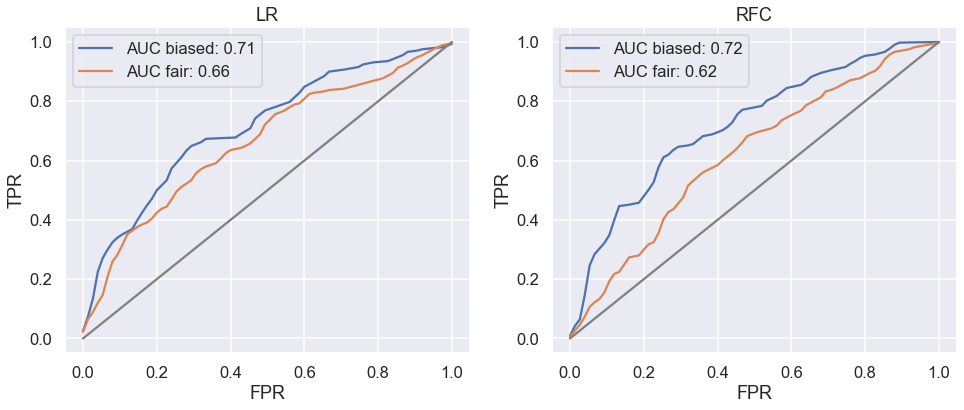

In [25]:
%matplotlib inline
def plot_auc(y_true: np.ndarray, preds: Dict[str, np.ndarray], title: str='', ax=None) -> None:
    leg = []
    for k, p in preds.items():
        fpr, tpr, _ = roc_curve(y_true, p)
        ax = sns.lineplot(x=fpr, y=tpr, ci=None, ax=ax)
        leg.append(f"{k}: {round(auc(fpr, tpr), 2)}")
   
    ax.legend(leg)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    sns.lineplot(x=[0, 1], y=[0, 1], color='gray',ax=ax)
    ax.set_title(title)
    
print('Accuracy:')
display(pd.DataFrame({'LogReg': [BiasedLogModel.score(X_test, y_test), 
                                 UnbiasedLogModel.score(X_lfr_test, y_lfr_test)],
                      'RFC': [BiasedRfcModel.score(X_test, y_test),
                              UnbiasedRfcModel.score(X_lfr_test, y_lfr_test)]}, 
                      index =['Biased', 'Fair']))

print('AUC:')

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16, 6))
plot_auc(y_test, 
         {'AUC biased': BiasedLogModel.predict_proba(X_test)[:, 1],
          'AUC fair': UnbiasedLogModel.predict_proba(X_lfr_test)[:, 1]},
         title='LR', ax=ax[0]) 
plot_auc(y_test, 
         {'AUC biased': BiasedRfcModel.predict_proba(X_test)[:, 1],
          'AUC fair': UnbiasedRfcModel.predict_proba(X_lfr_test)[:, 1]},
         title='RFC', ax=ax[1]) 
plt.show()

In [26]:
def feature_importance(mod: Union[LogisticRegression, RandomForestClassifier], names: List[str],scale=None) -> pd.DataFrame:
    """Return feature importance for LR or RFC models in a sorted DataFrame."""
    if type(mod) == LogisticRegression:
        imp = np.abs(mod.coef_.squeeze()) / scale
        var = np.zeros(shape=imp.shape)
    elif type(mod) == RandomForestClassifier:
        imps = np.array([fi.feature_importances_ for fi in mod.estimators_])
        imp = imps.mean(axis=0)
        var = imps.std(axis=0)

    return pd.DataFrame({'feature': names, 'importance': imp,
                         'std': var}).sort_values('importance', ascending=False)

def plot_feature_importance(**kwargs) -> None:
    ax = sns.barplot(**kwargs)
    for l in ax.get_xticklabels():
        l.set_rotation(90)

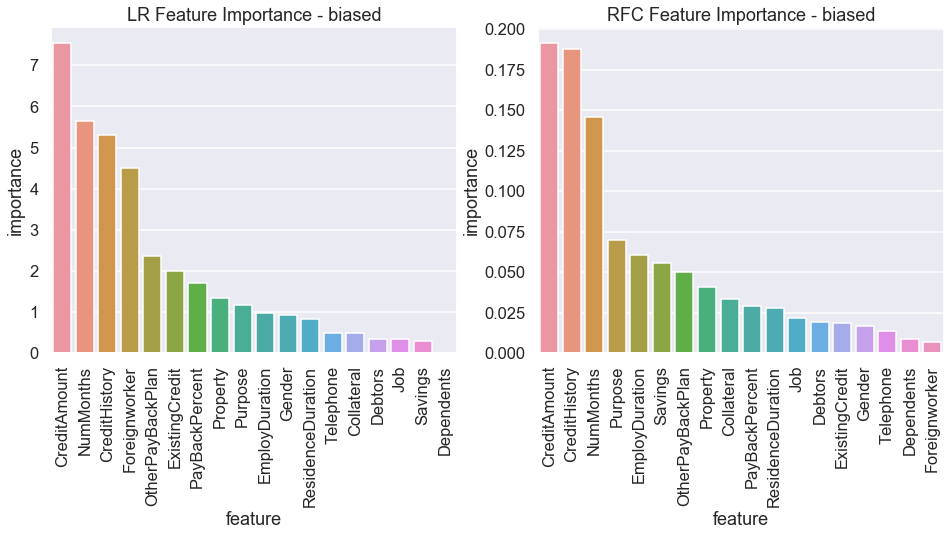

In [27]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

plot_feature_importance(x='feature', y='importance', 
                        data=feature_importance(BiasedLogModel, names=X_train.columns.tolist(),
                                                scale=X_train.std()), ax=ax[0])
_ = ax[0].set_title('LR Feature Importance - biased')
plot_feature_importance(x='feature', y='importance', 
                        data=feature_importance(BiasedRfcModel, names=X_train.columns.tolist()), ax=ax[1])
_ = ax[1].set_title('RFC Feature Importance - biased')

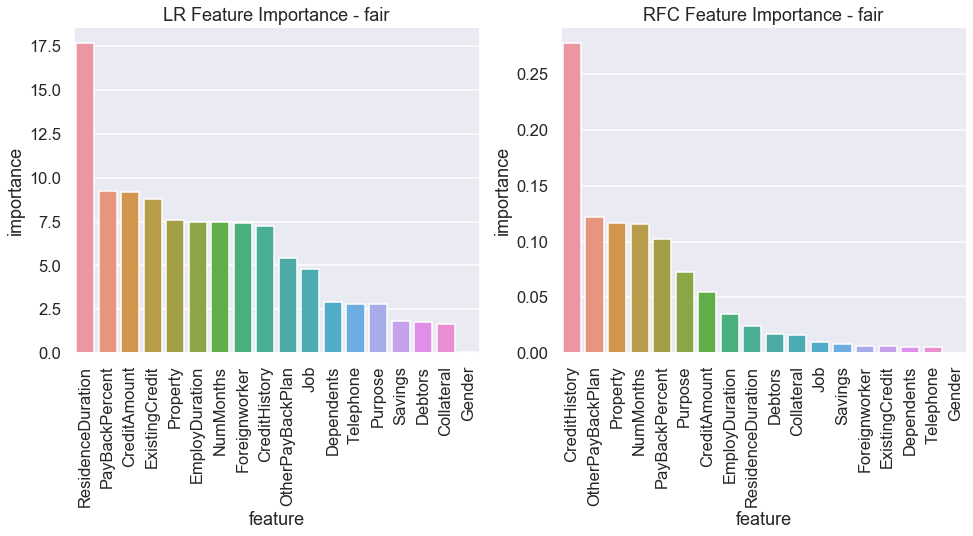

In [28]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

plot_feature_importance(x='feature', y='importance', 
                        data=feature_importance(UnbiasedLogModel, names=X_lfr_train.columns.tolist(), 
                                                scale=X_lfr_train.std()), ax=ax[0])
_ = ax[0].set_title('LR Feature Importance - fair')
plot_feature_importance(x='feature', y='importance', 
                        data=feature_importance(UnbiasedRfcModel, names=X_lfr_train.columns.tolist()), ax=ax[1])
_ = ax[1].set_title('RFC Feature Importance - fair')

In [29]:
def calc_metrics(mod, x: pd.DataFrame, y_true: pd.DataFrame) -> pd.DataFrame:
    """Calculate fairness metrics at each model threshold."""
    
    # Create a BinaryLabelDataset (as before training)
    bld = BinaryLabelDataset(df=pd.concat((x, y_true), axis=1),label_names=[lab],
                                  protected_attribute_names=[protected_attr],
                                  favorable_label=fav_label, unfavorable_label=unfav_label)

    # Create a second set to hold the predicted labels
    bld_preds = bld.copy(deepcopy=True)
    preds = mod.predict_proba(x)[:, 1] # for all the rows, retain the 2nd value.
                                       # preds will contain a single column table of all 
                                       # probabilities that the classification will be 1.
    accuracy          = []
    balanced_accuracy = []
    disp_impact       = []
    average_abs_odds_difference = []
    avg_odd_diff = []
    equal_opportunity_difference = []
    error_rate = []
    
    # For threshold values between 0 and 1:
    thresh = np.linspace(0.01, 0.99, 100) # generate 100 evenly spaced values from 0.01->0.99 
    for t in thresh:
        
        # Apply threshold and set labels in bld for predictions
        bld_preds.labels[preds > t] = 1  # labels is a structured dataset attribute.
        bld_preds.labels[preds <= t] = 0

        # Calculate the metrics for this threshold
        valid_metric = ClassificationMetric(bld, bld_preds, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

        # Save the balanced accuracy of the model, and the metrics
        accuracy.append(valid_metric.accuracy())
        balanced_accuracy.append(0.5 * (valid_metric.true_positive_rate()
                                        + valid_metric.true_negative_rate()))
#        disp_impact.append(np.abs(valid_metric.disparate_impact() - 0.5))
        disp_impact.append(np.abs(valid_metric.disparate_impact()))
        average_abs_odds_difference.append(valid_metric.average_abs_odds_difference())
        avg_odd_diff.append(valid_metric.average_odds_difference())
        equal_opportunity_difference.append(valid_metric.equal_opportunity_difference())
        error_rate.append(valid_metric.error_rate())

    # Return as df indexed by threshold
    metrics = pd.DataFrame({'accuracy': accuracy,
                            'balanced_accuracy': balanced_accuracy,
                            'disparate_impact': disp_impact,
                            'average_abs_odds_difference': average_abs_odds_difference,
                            'avg_odds_diff': avg_odd_diff,
                            'equal_opportunity_diff': equal_opportunity_difference},
                            index=thresh)
#'error_rate': error_rate},
    return metrics


def plot_metrics(metrics: pd.DataFrame, 
                 title: str='', **kwargs) -> None:
    """Plot the metrics df from calc_metrics with seaborn."""
    ax = sns.lineplot(data=metrics, 
                      **kwargs)
    ax.set_title(title)
    ax.set_xlabel('Classification threshold')

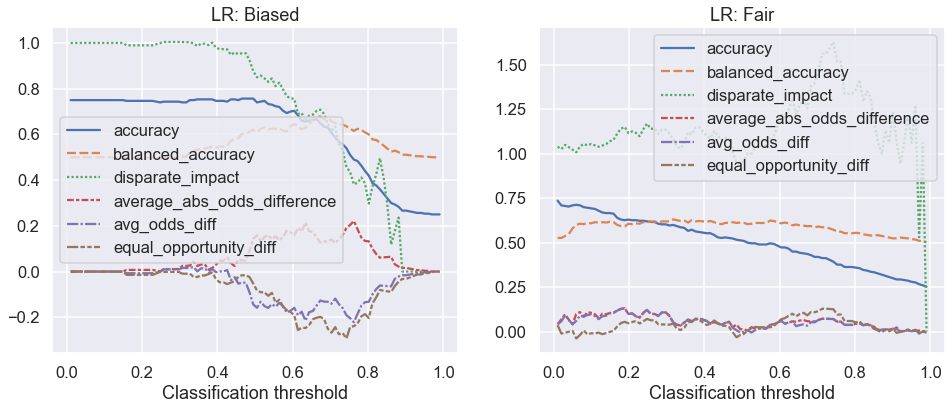

In [30]:
# Plot for Logistic Regression Classifier
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
with warnings.catch_warnings():
     warnings.simplefilter('ignore', RuntimeWarning)
    
     plot_metrics(calc_metrics(BiasedLogModel, X_test, y_test), ax=ax[0], title="LR: Biased")
 
     plot_metrics(calc_metrics(UnbiasedLogModel, X_lfr_test, y_lfr_test), ax=ax[1], title="LR: Fair")

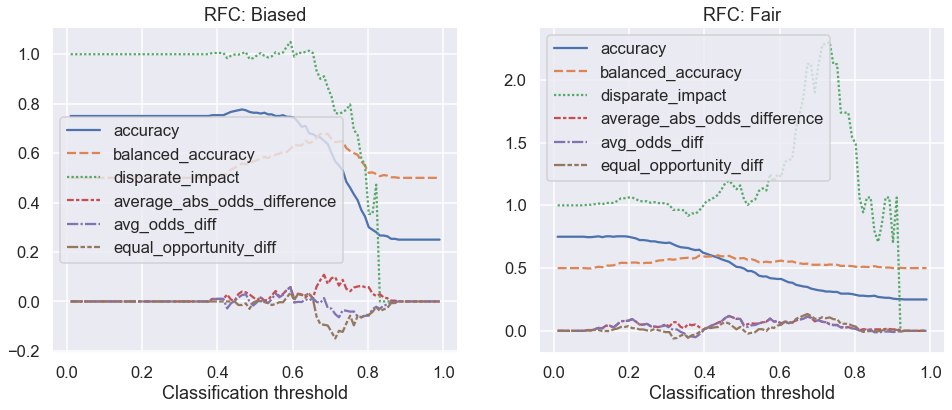

In [31]:
# Plot for Random Forest Classifier
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    
    plot_metrics(calc_metrics(BiasedRfcModel, X_test, y_test), ax=ax[0], title="RFC: Biased")
    
    plot_metrics(calc_metrics(UnbiasedRfcModel, X_lfr_test, y_lfr_test), ax=ax[1], title="RFC: Fair")

In [32]:
display(Markdown("#### Individual fairness metrics"))
print("Consistency of labels in transformed training dataset= %f" %metric_train_lfr.consistency())
print("Consistency of labels in original training dataset= %f" %metric_train_bld.consistency())

#### Individual fairness metrics

Consistency of labels in transformed training dataset= 0.972000
Consistency of labels in original training dataset= 0.696857


In [33]:
# Check whether the transform on the original dataset has worked. 
# A false means that the dataset is transformed.
German_train_lfr_df.equals(German_train_df)

False

In [34]:
German_train_df     = German_train_df.reset_index(drop=True)
German_train_lfr_df = German_train_lfr_df.reset_index(drop=True)
GermanBool          = (German_train_df != German_train_lfr_df).stack()  # Create Frame of comparison booleans
Germandiff          = pd.concat([German_train_df.stack()[GermanBool], German_train_lfr_df.stack()[GermanBool]], axis=1)
Germandiff.columns  =["German_train_df", "German_train_lfr"]
print(Germandiff)

                       German_train_df  German_train_lfr
0   NumMonths                 0.294118          0.840190
    CreditHistory             0.500000          0.774235
    Purpose                   0.333333          0.283608
    CreditAmount              0.059591          0.523722
    Savings                   0.250000          0.429244
    EmployDuration            0.750000          0.736449
    PayBackPercent            1.000000          1.176876
    Debtors                   0.000000          0.047649
    ResidenceDuration         0.333333          0.520814
    Collateral                0.000000          0.494680
    OtherPayBackPlan          0.000000          0.202722
    Property                  0.500000          0.463583
    ExistingCredit            0.333333         -0.070252
    Job                       0.000000          0.232292
    Dependents                1.000000          0.238905
    Telephone                 1.000000          0.869503
    Foreignworker             0

In [35]:
## PCA Analysis of consitency

In [36]:
# At this stage the transformed dataframe will have the last threshold encountered!
feat_cols = German_train_bld.feature_names

orig_df = pd.DataFrame(German_train_bld.features,columns=feat_cols)
orig_df['label'] = German_train_bld.labels
orig_df['label'] = orig_df['label'].apply(lambda i: str(i))

transf_df = pd.DataFrame(German_train_lfr.features,columns=feat_cols)
transf_df['label'] = German_train_lfr.labels
transf_df['label'] = transf_df['label'].apply(lambda i: str(i))

In [37]:
from sklearn.decomposition import PCA

orig_pca = PCA(n_components=3)
orig_pca_result = orig_pca.fit_transform(orig_df[feat_cols].values)

orig_df['pca-one'] = orig_pca_result[:,0]
orig_df['pca-two'] = orig_pca_result[:,1] 
orig_df['pca-three'] = orig_pca_result[:,2]

display(Markdown("#### Original training dataset"))
print('Explained variation per principal component:')
print(orig_pca.explained_variance_ratio_)

#### Original training dataset

Explained variation per principal component:
[0.15657076 0.13422009 0.10045203]


In [38]:
transf_pca = PCA(n_components=3)
transf_pca_result = transf_pca.fit_transform(transf_df[feat_cols].values)

transf_df['pca-one'] = transf_pca_result[:,0]
transf_df['pca-two'] = transf_pca_result[:,1] 
transf_df['pca-three'] = transf_pca_result[:,2]

display(Markdown("#### Transformed training dataset"))
print('Explained variation per principal component:')
print(transf_pca.explained_variance_ratio_)

#### Transformed training dataset

Explained variation per principal component:
[0.7318783  0.13640111 0.1138518 ]


In [39]:
###Load, clean up original test data and compute metric

In [40]:
display(Markdown("#### Testing Dataset shape"))
print(German_test_bld.features.shape)

metric_test_bld = BinaryLabelDatasetMetric(German_test_bld, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_test_bld.mean_difference())

#### Testing Dataset shape

(300, 18)


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.030637


In [41]:
###Transform test data and compute metric

In [42]:
German_test_lfr = TR.transform(German_test_bld, threshold=threshold)
metric_test_lfr = BinaryLabelDatasetMetric(German_test_lfr, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)

In [43]:
print("Consistency of labels in tranformed test dataset= %f" %metric_test_lfr.consistency())

Consistency of labels in tranformed test dataset= 0.977333


In [44]:
print("Consistency of labels in original test dataset= %f" %metric_test_bld.consistency())

Consistency of labels in original test dataset= 0.736000


In [45]:
def check_algorithm_success():
#   """Transformed dataset consistency should be greater than original dataset."""
    assert metric_test_lfr.consistency() > metric_test_bld.consistency(), "Transformed dataset consistency should be greater than original dataset."
print(check_algorithm_success())

None


In [46]:
# Is it possible to predict the Sensitive Variable from the transformed dataset
X_se_train = German_train_lfr_df.drop(protected_attr,axis=1)
y_se_train = German_train_lfr_df[protected_attr]
X_se_test  = German_test_df.drop(protected_attr,axis=1)
y_se_test  = German_test_df[protected_attr]

Se_UnbiasedLogModel = LogisticRegression(random_state=101)
Se_UnbiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)
Se_UnbiasedLogModel.fit(X_se_train, y_se_train) 
Se_UnbiasedRfcModel.fit(X_se_train, y_se_train) 
yseLog_pred =  Se_UnbiasedLogModel.predict(X_se_test)
yseRfc_pred =  Se_UnbiasedRfcModel.predict(X_se_test)
# Now test whether we can predict Gender from the test dataset
print('Model Accuracy for predicting the Sensitive Variable before bias transformation:')
print(f"Biased Logistic regression validation accuracy: {Se_UnbiasedLogModel.score(X_se_test, y_se_test)}")
print(f"Biased Random Forest       validation accuracy: {Se_UnbiasedRfcModel.score(X_se_test, y_se_test)}")
print('')
print('Biased Balanced accuracy')
print(f"Biased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_se_test, yseLog_pred)}")
print(f"Biased Random Forest       balanced accuracy  : {balanced_accuracy_score(y_se_test, yseRfc_pred)}")

Model Accuracy for predicting the Sensitive Variable before bias transformation:
Biased Logistic regression validation accuracy: 0.68
Biased Random Forest       validation accuracy: 0.6666666666666666

Biased Balanced accuracy
Biased Logistic regression balanced accuracy  : 0.5
Biased Random Forest       balanced accuracy  : 0.49019607843137253


In [47]:
# Next get the number of labels from the modified training dataset
print('Train ds Before - CreditStatus value counts:')
print(German_train_lfr_df.CreditStatus.value_counts())
print('Train ds Before - Gender value counts:')
print(German_train_lfr_df.Gender.value_counts())

Train ds Before - CreditStatus value counts:
1.0    356
0.0    344
Name: CreditStatus, dtype: int64
Train ds Before - Gender value counts:
1.0    486
0.0    214
Name: Gender, dtype: int64
